In [1]:
%matplotlib inline

In [15]:
import os
import numpy as np
import scipy.io as sio
import networkx as nx

from matplotlib import pyplot as plt

from helpers import (
    signed_laplacian, signed_layout, get_borderless_fig, draw_edges, pos_spring_layout,
    num_pos_edges, num_neg_edges,
)
from core import query_graph_using_sparse_linear_solver, sweep_on_x_fast

In [3]:
# pre-process graph
if not os.path.exists('data/word_graph.pkl'):
    mat_contents = sio.loadmat('data/word_sim_weighted.mat')

    A = mat_contents['Wemb']
    names = mat_contents['names']
    i2w = {i: names[i][0][0] for i in range(A.shape[0])}
    w2i = {w: i for i, w in i2w.items()}

    g = nx.from_scipy_sparse_matrix(A, edge_attribute='sign')

    gc = max(nx.connected_component_subgraphs(g), key=len)
    mapping = {n: i for i, n in enumerate(gc.nodes())}
    w2i_new = {i2w[old]: new for old, new in mapping.items()}
    i2w_new = {new: i2w[old] for old, new in mapping.items()}

    gc = nx.relabel_nodes(gc, mapping=mapping)
    w2i = w2i_new
    i2w = i2w_new
    del g
    gc.graph['w2i'] = w2i
    gc.graph['i2w'] = i2w
    nx.write_gpickle(gc, 'data/word_graph.pkl')
else:
    # load pre-processed graph
    g = nx.read_gpickle('data/word_graph.pkl')
    w2i = g.graph['w2i']
    i2w = g.graph['i2w']    

In [16]:
print('graph dimension:', g.number_of_nodes(), g.number_of_edges())
print('#pos edges, #neg edges:', num_pos_edges(g), num_neg_edges(g))

graph dimension: 4962 47088
#pos edges, #neg edges: 37723 9365


In [5]:
def pos_nbrs(g, word):
    s = w2i[word]
    return [i2w[n] for n in g.neighbors(s) if g[s][n]['sign'] > 0]

def neg_nbrs(g, word):
    s = w2i[word]
    return [i2w[n] for n in g.neighbors(s) if g[s][n]['sign'] < 0]

print(' '.join(pos_nbrs(g, 'happy')))
print(' '.join(neg_nbrs(g, 'happy')))

light content meet fit fitting cheerful successful jolly good nice proper glad accidental right promising upbeat ready well willing incidental sparkling smiling
poor melancholic down blue serious dark ashamed downcast boiling disagreeable upset unhappy heavy sad unfortunate


In [53]:
def demo(word1, word2=None, kappa=0.5, top_k=-1, show_sweep_plot=True, show_subgraph=True):
    seeds = [[w2i[word1]]]
    if word2 is not None:
        seeds.append([w2i[word2]])

    x_opt, opt_val = query_graph_using_sparse_linear_solver(g, seeds, kappa=kappa, solver='cg', verbose=0)
    c1, c2, C, best_t, best_sbr, ts, sbr_list = sweep_on_x_fast(g, x_opt, top_k=top_k, verbose=0)

    if show_sweep_plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(sbr_list, '.-')
        ax.set_xlabel('number of nodes included')
        ax.set_ylabel('beta')
        ax.axvline(best_t, color='red')         
        ax.set_title('sweeping profile')
    
    c1_words = [i2w[n] for n in c1]
    c2_words = [i2w[n] for n in c2]
    print('community 1 has {} nodes\nthey are:'.format(len(c1)))
    print(' '.join(c1_words)[:200])
    print()
    print('community 1 has {} nodes\nthey are:'.format(len(c2)))
    print(' '.join(c2_words)[:200])

    if show_subgraph:
        try:
            subg = g.subgraph(C)

            subg = nx.convert_node_labels_to_integers(subg)

            pos = pos_spring_layout(subg)

            fig, ax = get_borderless_fig()
            # draw_nodes(subg, pos, ax=ax)
            nx.draw_networkx_nodes(subg, pos, node_size=10, linewidths=0, alpha=0.5, node_color='black')
            draw_edges(subg, pos, ax=ax, width=1.0, alpha=0.5)
        except:
            print('unable to plot')
            pass
    return c1_words, c2_words, dict(x_opt=x_opt)

community 1 has 2513 nodes
they are:
happy glad jolly absorbent uplifting promising cheerful smiling accidental beautiful hopeful upbeat content well sparkling proud sweetened willing freezing skillfully freely antiseptic blonde charcoal

community 1 has 2448 nodes
they are:
unhappy ashamed melancholic unfortunate boiling downcast penitent defeatist sad disagreeable downbeat broiling worrying hurting blue dreary brunette insurgent impromptu repellent navy moody down disco


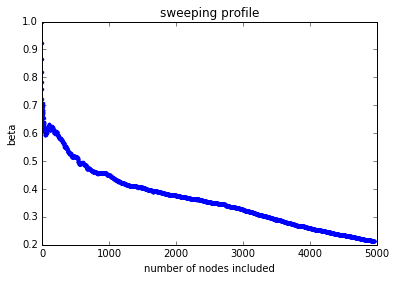

In [47]:
exp1_c1, exp1_c2, exp1 = demo('happy', 'unhappy', kappa=0.8, top_k=-1, show_subgraph=False)

community 1 has 194 nodes
they are:
happy glad jolly absorbent uplifting promising cheerful smiling accidental beautiful hopeful upbeat content well sparkling proud sweetened willing freezing skillfully freely antiseptic blonde charcoal

community 1 has 201 nodes
they are:
unhappy ashamed melancholic unfortunate boiling downcast penitent defeatist sad disagreeable downbeat broiling worrying hurting blue dreary brunette insurgent impromptu repellent navy moody down disco


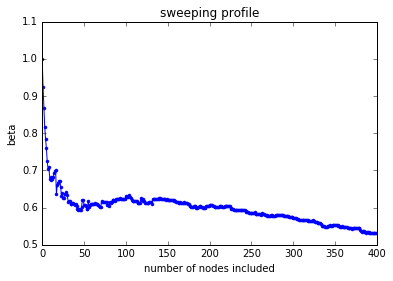

In [48]:
exp1_c1, exp1_c2, exp1 = demo('happy', 'unhappy', kappa=0.8, top_k=400, show_subgraph=False)

community 1 has 23 nodes
they are:
happy glad jolly absorbent uplifting promising cheerful smiling accidental beautiful hopeful upbeat content well sparkling proud sweetened willing freezing skillfully freely antiseptic blonde

community 1 has 21 nodes
they are:
unhappy ashamed melancholic unfortunate boiling downcast penitent defeatist sad disagreeable downbeat broiling worrying hurting blue dreary brunette insurgent impromptu repellent navy


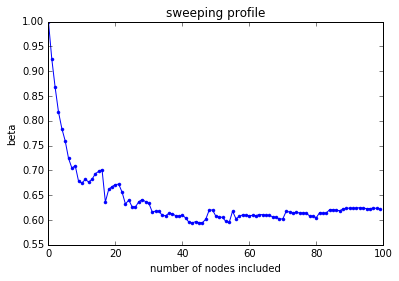

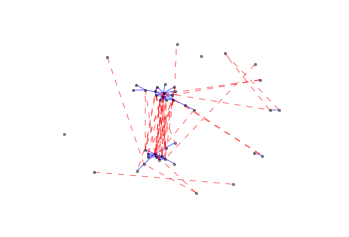

In [54]:
exp1_c1, exp1_c2, exp1 = demo('happy', 'unhappy', kappa=0.8, top_k=100, show_subgraph=True)

In [55]:
def set_comp(s1, s2):
    s1, s2 = set(s1), set(s2)
    print('s1 - s2:', ', '.join(s1 - s2))
    print('s2 - s1:', ', '.join(s2 - s1))
    print('s2 AND s1:', ', '.join(s1.intersection(s2)))
    
def rank_of_word(scores, word):
    order = np.argsort(scores)
    return (order == w2i[word]).nonzero()[0][0]


In [56]:
print('rank of "happy"', rank_of_word(exp1['x_opt'], 'happy'))
print('rank of "unhappy"', rank_of_word(exp1['x_opt'], 'unhappy'))
print('max rank', g.number_of_nodes() - 1)

rank of "happy" 4961
rank of "unhappy" 0
max rank 4961


In [57]:
print('set difference with positive nbrs:\n')
set_comp(exp1_c2, pos_nbrs(g, 'happy'))
print('-' * 10)
set_comp(exp1_c1, pos_nbrs(g, 'unhappy'))

set difference with positive nbrs:

s1 - s2: melancholic, navy, repellent, blue, insurgent, disagreeable, penitent, unfortunate, impromptu, broiling, downbeat, hurting, defeatist, unhappy, sad, downcast, dreary, ashamed, boiling, brunette, worrying
s2 - s1: glad, fit, ready, successful, upbeat, content, smiling, accidental, incidental, light, nice, right, fitting, good, cheerful, meet, proper, jolly, sparkling, well, promising, willing
s2 AND s1: 
----------
s1 - s2: absorbent, glad, proud, antiseptic, upbeat, content, smiling, accidental, skillfully, beautiful, blonde, cheerful, hopeful, happy, jolly, freely, freezing, sparkling, uplifting, well, promising, sweetened, willing
s2 - s1: melancholic, wrong, low, melancholy, sad, downcast, repellent, acid, hurt, unfortunate, hurting, downbeat, poor, rough, blue, bad, forbidding, dreary, caustic, bitter, harsh, tart, sore, dark, sharp, down
s2 AND s1: 


community 1 has 1 nodes
they are:
illiterate

community 1 has 1 nodes
they are:
literate


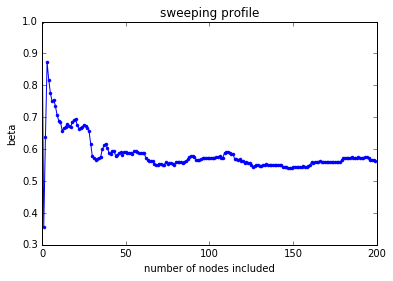

In [61]:
_, _, exp2 = demo('happy', 'unhappy', kappa=0.5, top_k=200, show_subgraph=False)

In [62]:
order = np.argsort(exp2['x_opt'])
print('first and last word by x_opt: ', i2w[order[0]], i2w[order[-1]])
exp2['x_opt']
print('indices of "happy" and "unhappy" by x_opt: ',
      (order == w2i['happy']).nonzero()[0][0],
      (order == w2i['unhappy']).nonzero()[0][0]
)
print('max index {}'.format(g.number_of_nodes()-1))


first and last word by x_opt:  literate illiterate
indices of "happy" and "unhappy" by x_opt:  4960 2
max index 4961


community 1 has 15 nodes
they are:
happy glad promising accidental uplifting jolly smiling sparkling upbeat hopeful proud freezing cheerful willing successful

community 1 has 13 nodes
they are:
ashamed melancholic unfortunate boiling penitent downcast disagreeable unhappy broiling sad defeatist blue worrying


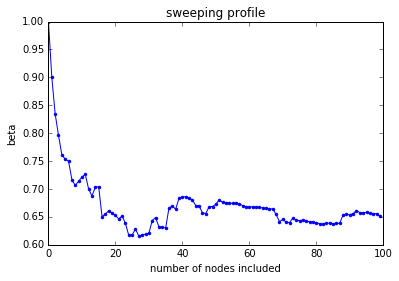

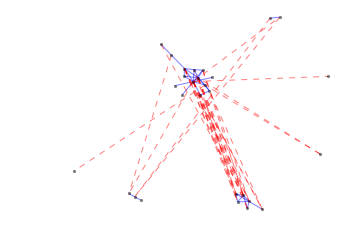

In [65]:
exp3_c1, exp3_c2, exp3 = demo('happy', kappa=0.8, show_subgraph=True, top_k=100)

In [66]:
print('rank of "happy"', rank_of_word(exp3['x_opt'], 'happy'))
print('rank of "unhappy"', rank_of_word(exp3['x_opt'], 'unhappy'))

rank of "happy" 4961
rank of "unhappy" 7


# observation


- "irrelevant" communities (that are connected to the main one by negative edges) can be returned, which is less meaningful
  - a reasonable post-processing step: remove nodes that are solely connected by negative edges (or do a BFS on the positive graph)
- if $\kappa$ is set too low (e.g, 0.5), seeds will not rank top and sweeping result might not include the seeds
  - this implies that a good $\kappa$ should ensure seeds are included in the sweeping result or they rank high in `x_opt`
- however, if $\kappa$ set high enough (0.8 for example), seeds are included

## update (May 7)

- if `top_k` set to large, the entire graph will be included because doing so gives a large denumerator, so in practice, it's better to set`top_k` not too large


# sweep on $v_1$

In [7]:
from helpers import get_v1
v1 = get_v1(g)

In [9]:
from core import sweep_on_x
c1, c2, C, best_t, best_sbr, ts, sbr_list = sweep_on_x_fast(g, v1, verbose=0)

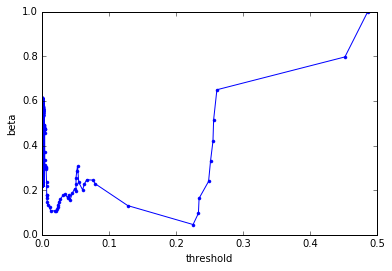

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(ts, sbr_list, '.-')
ax.set_xlabel('threshold')
ax.set_ylabel('beta')

In [11]:
print('min beta=', best_sbr)

min beta= 0.045978063950136566


In [12]:
' '.join([i2w[w] for w in c1]), ' '.join([i2w[w] for w in c2])

('landlord landowner landholder homeowner landlady',
 'tenant renter lessee leaseholder boarder')